In [1]:
import os, pymongo, json, pandas
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

## Setup you'll need to do before you can download data from your server

In order to access the database on your server, you'll need two things. 

1. You'll need to open up a trusted line of communication from computer where you'll be analyzing the data (e.g. your desktop) to the server. 

    You can do this by modifying the following line of code to match your local configurations and entering it in from the command line: 

    `ssh -fNL 27017:localhost:27017 <USERNAME>@<DOMAIN_NAME>`

    It will ask you for your password--the same password you'd use to log onto your server


2. You'll need the the username and password from the (mongo) database itself. You'll find this information in the 'mongo_keys' file int the 'credentials/' folder on your server. 
    
    Copy a version of 'mongo_keys' onto the computer you'll be analyzing data on (we'll call that location `PATH_TO_MONGO_KEYS`)  

## Step by step code to connect with your server 

In [2]:
PATH_TO_MONGO_KEYS = '<YOUR_PATH>'
PATH_TO_MONGO_KEYS = '/Users/biota/work/mtl_perception/high-throughput/online_experiment/credentials/'#

In [3]:
# mongo key name
mongo_keys = 'mongo_keys'

# load our mongo access keys
access_info = json.load(open(os.path.join(PATH_TO_MONGO_KEYS, mongo_keys)))

# set up the 'tunnel' we'll be using to access the server (which we opened above)
mongo_tunnel = 'mongodb://' + access_info['user'] + ':' + access_info['pwd'] + '@127.0.0.1'

# conect to the mongo client on the server
connection_to_server = pymongo.MongoClient(mongo_tunnel)

## Extracting data from a particular database

Here, "connection_to_server" is the umbrella connection that you'll use to set up a connection to the specific `database` and `collection` where your data have been stored. It's a good idea to go over a tutorial online about how these work, but mongo databases have a generic structure: 

- Mongo Database (running on your server) 

    - Database A 

        - Collection A
            - Document 1
            - Document 2
            - ... 
            - Document N
        - Collection B 
    - Database B 
        - ... 
    - ... 


Whenever we save a document, we have to specify which database and collection that document is saved into. In the `hello_world` demo, we've specified that in the `app.js` file at `server_side_psych/experiment_setup/hello_world/app.js`.  

Line 83 specifies the database (`db`) and collection (`collection`): 
 
 
`var collection = client.db('hello_world_database').collection('comments')`


This means that all the documents you save are going to be stored like this
- Mongo Database (running on your server) 

    - hello_world_database 
        - comments
            - Document 1
            - Document 2 
            - ... 
        
Once we've gone through the whole tutorial, let's connect to the database that contains all our collections: 

In [8]:
# define database we want to connect to
mongo_database = 'tutorial'

# connect to the database
data_base = connection_to_server[mongo_database]

and look at all the collects we have, which correspond to the collection names in the `app.js` file: 

In [9]:
data_base.list_collection_names() 

['hello_world']

First let's collect some of the data from `hello_world`: 

In [17]:
# define collection we want to connect to
mongo_collection = 'hello_world'

# connect to the collection
collection = data_base[mongo_collection]

# extract ever document into a list 
collection_documents = list( collection.find() ) 

In [18]:
collection_documents # requires that there is at least one document saved to the database :) 

[{'_id': ObjectId('60548f6fbb22040bcc8349f7'), 'text_input': '0'},
 {'_id': ObjectId('60548f71bb22040bcc8349f8'), 'text_input': '1'},
 {'_id': ObjectId('60548f72bb22040bcc8349f9'), 'text_input': '2'},
 {'_id': ObjectId('60548f73bb22040bcc8349fa'), 'text_input': '3'}]

And let's just look at the first thing you saved: 

Let's visualize some of the reaction time data from the `jsPsych_demo` experiment. The database is the same, but the collection is different. So let's change the collection we're connected to: 

In [45]:
# define collection we want to connect to
mongo_collection = 'jsPsych_demo'

# connect to the collection
collection = data_base[mongo_collection]

In [46]:
#collection.delete_many({})

In [71]:
# first let's extract all the reaction time trials we've collected 
jsPsych_demo = [i for i in collection.find()]

# then let's convert this to a pandas dataframe
jsPsych_demo = pandas.DataFrame(jsPsych_demo)

# # ... select only the columns we want 
jsPsych_demo = rt_dataframe[['stimulus', 'response', 'rt', 'correct_response', 'time_elapsed']]

In [72]:
jsPsych_demo

,stimulus,response,rt,correct_response,time_elapsed
0,orange,j,545.370,j,6864
1,blue,f,415.490,f,8535
2,orange,j,626.330,j,10416
3,blue,f,563.245,f,11254
4,blue,f,637.690,f,12917
5,orange,j,640.900,j,15561
6,blue,f,540.670,f,16353
7,orange,j,539.730,j,17145
8,orange,j,655.155,j,18552
9,blue,f,448.470,f,20504


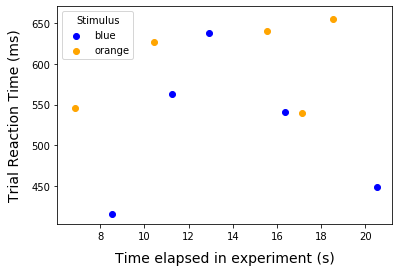

In [73]:
for i_color in ['blue', 'orange']: 
    df_color = jsPsych_demo[jsPsych_demo.stimulus==i_color]
    plt.scatter(x=df_color.time_elapsed/1000, y=df_color.rt, color=i_color, label=i_color)

plt.legend(title='Stimulus')
plt.xlabel('Time elapsed in experiment (s)', fontsize=14, labelpad=10)
plt.ylabel('Trial Reaction Time (ms)', fontsize=14, labelpad=10); 

In [74]:
# define collection we want to connect to
mongo_collection = 'mturk_demo'

# connect to the collection
collection = data_base[mongo_collection]

In [86]:
# first let's extract all the reaction time trials we've collected 
jsPsych_demo = [i for i in collection.find()]

# then let's convert this to a pandas dataframe
mturk_demo = pandas.DataFrame(jsPsych_demo)

# # # ... select only the columns we want 
mturk_demo = mturk_demo[['stimulus', 'response', 'rt', 'correct_response', 'time_elapsed', 'worker_id']]

# cleanup names of stimuli
mturk_demo['stimulus'] = [trial[8:-4] for trial in mturk_demo['stimulus']]

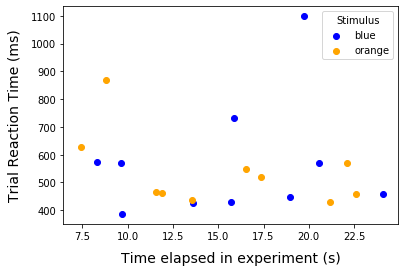

In [87]:
for i_color in ['blue', 'orange']: 
    df_color = mturk_demo[mturk_demo.stimulus==i_color]
    plt.scatter(x=df_color.time_elapsed/1000, y=df_color.rt, color=i_color, label=i_color)

plt.legend(title='Stimulus')
plt.xlabel('Time elapsed in experiment (s)', fontsize=14, labelpad=10)
plt.ylabel('Trial Reaction Time (ms)', fontsize=14, labelpad=10); 